# Image Classification Model Based on a Convolutional Neural Network with PyTorch

The following notebook contains a Convolutional Neural Network (CNN) used to identify if an image contains a circle, square or triangle.

In [13]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from random import randint
import ipywidgets as widgets
from IPython.display import display, clear_output
from random import randint
from PIL import Image, ImageDraw

## 1. Load data

The cell beow containse an iterative loader for training data, and a second iterative loader for test data. The loaders will transform the image data into *tensors*, which are the core data structure used in PyTorch, and normalize them so that the pixel values are in a scale with a mean of 0.5 and a standard deviation of 0.5.

In [14]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Now load the images from the shapes folder
data_path = 'data/shapes/'

# Get the class names
classes = os.listdir(data_path)
classes.sort()

print('The dataset contains', len(classes), 'image classes:')
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)

The dataset contains 3 image classes:
['circle', 'square', 'triangle']


## 2. Define the CNN

In PyTorch, a neural network model as a class that is derived from the **nn.Module** base class. The class must define the layers in the network, and provide a **forward** method that is used to process data through the layers of the network. In the cell below the CNN is defined.

In [15]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


## 3. Train the model

The model can now be trained using the image data.

The training consists of an iterative series of forward passes in which the training data is processed in batches by the layers in the network, and the optimizer goes back and adjusts the weights. A separate set of test images will be used to test the model at the end of each iteration (or *epoch*) so the performance improvement can be tracked as the training progresses.

50 epochs are used to train the model using the batches of images loaded by the data loaders, holding back the data in the test data loader for validation. After each epoch, a loss function measures the error (*loss*) in the model and adjusts the weights (which were randomly generated for the first iteration) to try to improve accuracy. 

It should be noted that at this point a previously saved model is loaded to reduce the loading time of the notebook as training the model takes a considerable amount of time on mybinder. However, the code to train the model can be found here: https://mybinder.org/v2/gh/guypwhunt/deep_neural_network/HEAD?filepath=convolutional_neural_networks_pytorch.ipynb

In [16]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    
# Delete 'x =' below and uncomment the remaining code to train the model 
x = """device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)"""

In [17]:
epoch_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
training_loss = [1.0012142728356754, 0.5135973306263194, 0.2907167567926295, 0.1566463686964091, 0.12172643533524345, 0.0652787965886733, 0.04081264992847162, 0.038378451074309206, 0.0345699954777956, 0.02172902746893027, 0.03890544439063353, 0.016187263695482054, 0.007589282118715346, 0.008064666937571019, 0.006214961878654054, 0.015086331000715932, 0.013507066907443325, 0.01477325233110391, 0.007408273416598711, 0.004513079639496829, 0.005367005959509269, 0.003934128608842216, 0.0015826551774379743, 0.002613745237741729, 0.0023829116390141495, 0.0014075274670818437, 0.0008194782218625358, 0.0008938396315309493, 0.0006066296880496392, 0.0006166334582410534, 0.001401052661736578, 0.006307438349026865, 0.0022078641460907154, 0.0026143413619780296, 0.0021404172713279396, 0.0015406526149223175, 0.001366157220913652, 0.0005554087545747546, 0.0005784737281561213, 0.000593931621979744, 0.0004682258027862511, 0.0017148349452862236, 0.0003167820304952329, 0.000127819750131868, 0.00020441709415643024, 0.00018004282628680812, 0.00031255880789745683, 0.00017861491767903585, 0.0005856147971130934, 0.0020370626931681354]
validation_loss = [0.6673303097486496, 0.30568786710500717, 0.1965186232700944, 0.10293586342595518, 0.06530656665563583, 0.04304971219971776, 0.022525178152136505, 0.01790400079335086, 0.013899762998335063, 0.014631185069447383, 0.015811252873390913, 0.010235420180833898, 0.004511535444180481, 0.003531531625412754, 0.005147198820168342, 0.005417024754024169, 0.0028075429545424413, 0.004791191813751539, 0.0021507866513275076, 0.0024289254579343833, 0.00194900297174172, 0.0013920017663622275, 0.0015894820180619718, 0.0009377644146297826, 0.0008549574049538933, 0.0006199660510901595, 0.0006358291575452313, 0.0005021533347644436, 0.00048047361360659124, 0.0004245713819273078, 0.0003946199022948349, 0.0006263376369588514, 0.0006867554110385754, 0.0007179843737219471, 0.0004158226377057872, 0.000575107684426257, 0.00067178004633206, 0.00025096282527670155, 0.00025330326118933044, 0.0002704071770125438, 0.00023775113023560834, 0.0005064000172581018, 0.0002101199740991433, 0.00017247251301455435, 0.00015352206485630404, 0.00014542134262995887, 0.0001605216949585042, 0.0001472401715716387, 0.000486813393678176, 0.0006943353153303633]

training_results = """
Epoch: 1
Training set [0/840 (0%)] Loss: 1.103770
Training set [500/840 (59%)] Loss: 0.767837
Training set: Average loss: 0.825230
Validation set: Average loss: 0.476628, Accuracy: 290/360 (81%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.511575
Training set [500/840 (59%)] Loss: 0.308371
Training set: Average loss: 0.388326
Validation set: Average loss: 0.301778, Accuracy: 302/360 (84%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.354706
Training set [500/840 (59%)] Loss: 0.261062
Training set: Average loss: 0.256638
Validation set: Average loss: 0.168473, Accuracy: 335/360 (93%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.168978
Training set [500/840 (59%)] Loss: 0.117388
Training set: Average loss: 0.138040
Validation set: Average loss: 0.090180, Accuracy: 351/360 (98%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.100226
Training set [500/840 (59%)] Loss: 0.065538
Training set: Average loss: 0.071896
Validation set: Average loss: 0.044922, Accuracy: 356/360 (99%)

Epoch: 6
Training set [0/840 (0%)] Loss: 0.034637
Training set [500/840 (59%)] Loss: 0.036014
Training set: Average loss: 0.043303
Validation set: Average loss: 0.023202, Accuracy: 360/360 (100%)

Epoch: 7
Training set [0/840 (0%)] Loss: 0.022999
Training set [500/840 (59%)] Loss: 0.055200
Training set: Average loss: 0.034087
Validation set: Average loss: 0.022698, Accuracy: 357/360 (99%)

Epoch: 8
Training set [0/840 (0%)] Loss: 0.029490
Training set [500/840 (59%)] Loss: 0.018004
Training set: Average loss: 0.041226
Validation set: Average loss: 0.018746, Accuracy: 359/360 (100%)

Epoch: 9
Training set [0/840 (0%)] Loss: 0.019401
Training set [500/840 (59%)] Loss: 0.008904
Training set: Average loss: 0.018305
Validation set: Average loss: 0.009203, Accuracy: 360/360 (100%)

Epoch: 10
Training set [0/840 (0%)] Loss: 0.016958
Training set [500/840 (59%)] Loss: 0.013551
Training set: Average loss: 0.012223
Validation set: Average loss: 0.005830, Accuracy: 360/360 (100%)

Epoch: 11
Training set [0/840 (0%)] Loss: 0.020725
Training set [500/840 (59%)] Loss: 0.007458
Training set: Average loss: 0.017074
Validation set: Average loss: 0.004759, Accuracy: 360/360 (100%)

Epoch: 12
Training set [0/840 (0%)] Loss: 0.006093
Training set [500/840 (59%)] Loss: 0.003227
Training set: Average loss: 0.008680
Validation set: Average loss: 0.002621, Accuracy: 360/360 (100%)

Epoch: 13
Training set [0/840 (0%)] Loss: 0.008323
Training set [500/840 (59%)] Loss: 0.003433
Training set: Average loss: 0.004586
Validation set: Average loss: 0.003536, Accuracy: 360/360 (100%)

Epoch: 14
Training set [0/840 (0%)] Loss: 0.005679
Training set [500/840 (59%)] Loss: 0.002220
Training set: Average loss: 0.003429
Validation set: Average loss: 0.002008, Accuracy: 360/360 (100%)

Epoch: 15
Training set [0/840 (0%)] Loss: 0.008813
Training set [500/840 (59%)] Loss: 0.001869
Training set: Average loss: 0.005016
Validation set: Average loss: 0.003085, Accuracy: 360/360 (100%)

Epoch: 16
Training set [0/840 (0%)] Loss: 0.010281
Training set [500/840 (59%)] Loss: 0.002442
Training set: Average loss: 0.003687
Validation set: Average loss: 0.001785, Accuracy: 360/360 (100%)

Epoch: 17
Training set [0/840 (0%)] Loss: 0.004554
Training set [500/840 (59%)] Loss: 0.000509
Training set: Average loss: 0.004108
Validation set: Average loss: 0.001743, Accuracy: 360/360 (100%)

Epoch: 18
Training set [0/840 (0%)] Loss: 0.003746
Training set [500/840 (59%)] Loss: 0.000447
Training set: Average loss: 0.004889
Validation set: Average loss: 0.003176, Accuracy: 360/360 (100%)

Epoch: 19
Training set [0/840 (0%)] Loss: 0.010371
Training set [500/840 (59%)] Loss: 0.005106
Training set: Average loss: 0.004751
Validation set: Average loss: 0.002028, Accuracy: 360/360 (100%)

Epoch: 20
Training set [0/840 (0%)] Loss: 0.002068
Training set [500/840 (59%)] Loss: 0.000766
Training set: Average loss: 0.002941
Validation set: Average loss: 0.001435, Accuracy: 360/360 (100%)

Epoch: 21
Training set [0/840 (0%)] Loss: 0.005506
Training set [500/840 (59%)] Loss: 0.000672
Training set: Average loss: 0.004504
Validation set: Average loss: 0.000623, Accuracy: 360/360 (100%)

Epoch: 22
Training set [0/840 (0%)] Loss: 0.000773
Training set [500/840 (59%)] Loss: 0.000171
Training set: Average loss: 0.002254
Validation set: Average loss: 0.000901, Accuracy: 360/360 (100%)

Epoch: 23
Training set [0/840 (0%)] Loss: 0.000373
Training set [500/840 (59%)] Loss: 0.000964
Training set: Average loss: 0.001514
Validation set: Average loss: 0.000947, Accuracy: 360/360 (100%)

Epoch: 24
Training set [0/840 (0%)] Loss: 0.003218
Training set [500/840 (59%)] Loss: 0.001212
Training set: Average loss: 0.001670
Validation set: Average loss: 0.000543, Accuracy: 360/360 (100%)

Epoch: 25
Training set [0/840 (0%)] Loss: 0.000807
Training set [500/840 (59%)] Loss: 0.000227
Training set: Average loss: 0.001656
Validation set: Average loss: 0.000662, Accuracy: 360/360 (100%)

Epoch: 26
Training set [0/840 (0%)] Loss: 0.003577
Training set [500/840 (59%)] Loss: 0.001073
Training set: Average loss: 0.001544
Validation set: Average loss: 0.000604, Accuracy: 360/360 (100%)

Epoch: 27
Training set [0/840 (0%)] Loss: 0.000407
Training set [500/840 (59%)] Loss: 0.000722
Training set: Average loss: 0.000939
Validation set: Average loss: 0.000369, Accuracy: 360/360 (100%)

Epoch: 28
Training set [0/840 (0%)] Loss: 0.000877
Training set [500/840 (59%)] Loss: 0.000544
Training set: Average loss: 0.001112
Validation set: Average loss: 0.000334, Accuracy: 360/360 (100%)

Epoch: 29
Training set [0/840 (0%)] Loss: 0.000067
Training set [500/840 (59%)] Loss: 0.000113
Training set: Average loss: 0.000540
Validation set: Average loss: 0.000295, Accuracy: 360/360 (100%)

Epoch: 30
Training set [0/840 (0%)] Loss: 0.000195
Training set [500/840 (59%)] Loss: 0.000206
Training set: Average loss: 0.000591
Validation set: Average loss: 0.000266, Accuracy: 360/360 (100%)

Epoch: 31
Training set [0/840 (0%)] Loss: 0.001124
Training set [500/840 (59%)] Loss: 0.000479
Training set: Average loss: 0.000264
Validation set: Average loss: 0.000234, Accuracy: 360/360 (100%)

Epoch: 32
Training set [0/840 (0%)] Loss: 0.000124
Training set [500/840 (59%)] Loss: 0.000080
Training set: Average loss: 0.000206
Validation set: Average loss: 0.000190, Accuracy: 360/360 (100%)

Epoch: 33
Training set [0/840 (0%)] Loss: 0.001023
Training set [500/840 (59%)] Loss: 0.000355
Training set: Average loss: 0.001589
Validation set: Average loss: 0.001113, Accuracy: 360/360 (100%)

Epoch: 34
Training set [0/840 (0%)] Loss: 0.003400
Training set [500/840 (59%)] Loss: 0.001123
Training set: Average loss: 0.001529
Validation set: Average loss: 0.000538, Accuracy: 360/360 (100%)

Epoch: 35
Training set [0/840 (0%)] Loss: 0.002004
Training set [500/840 (59%)] Loss: 0.000121
Training set: Average loss: 0.000367
Validation set: Average loss: 0.000241, Accuracy: 360/360 (100%)

Epoch: 36
Training set [0/840 (0%)] Loss: 0.000106
Training set [500/840 (59%)] Loss: 0.000192
Training set: Average loss: 0.001116
Validation set: Average loss: 0.000365, Accuracy: 360/360 (100%)

Epoch: 37
Training set [0/840 (0%)] Loss: 0.002517
Training set [500/840 (59%)] Loss: 0.000053
Training set: Average loss: 0.000862
Validation set: Average loss: 0.000899, Accuracy: 360/360 (100%)

Epoch: 38
Training set [0/840 (0%)] Loss: 0.002131
Training set [500/840 (59%)] Loss: 0.004033
Training set: Average loss: 0.000825
Validation set: Average loss: 0.000199, Accuracy: 360/360 (100%)

Epoch: 39
Training set [0/840 (0%)] Loss: 0.000515
Training set [500/840 (59%)] Loss: 0.000113
Training set: Average loss: 0.000290
Validation set: Average loss: 0.000270, Accuracy: 360/360 (100%)

Epoch: 40
Training set [0/840 (0%)] Loss: 0.000114
Training set [500/840 (59%)] Loss: 0.000817
Training set: Average loss: 0.001884
Validation set: Average loss: 0.000255, Accuracy: 360/360 (100%)

Epoch: 41
Training set [0/840 (0%)] Loss: 0.000065
Training set [500/840 (59%)] Loss: 0.005661
Training set: Average loss: 0.001219
Validation set: Average loss: 0.000349, Accuracy: 360/360 (100%)

Epoch: 42
Training set [0/840 (0%)] Loss: 0.000018
Training set [500/840 (59%)] Loss: 0.000113
Training set: Average loss: 0.000766
Validation set: Average loss: 0.001409, Accuracy: 360/360 (100%)

Epoch: 43
Training set [0/840 (0%)] Loss: 0.000396
Training set [500/840 (59%)] Loss: 0.001350
Training set: Average loss: 0.004553
Validation set: Average loss: 0.000240, Accuracy: 360/360 (100%)

Epoch: 44
Training set [0/840 (0%)] Loss: 0.000075
Training set [500/840 (59%)] Loss: 0.000098
Training set: Average loss: 0.001293
Validation set: Average loss: 0.001481, Accuracy: 360/360 (100%)

Epoch: 45
Training set [0/840 (0%)] Loss: 0.007187
Training set [500/840 (59%)] Loss: 0.000083
Training set: Average loss: 0.000710
Validation set: Average loss: 0.000188, Accuracy: 360/360 (100%)

Epoch: 46
Training set [0/840 (0%)] Loss: 0.000055
Training set [500/840 (59%)] Loss: 0.000026
Training set: Average loss: 0.000877
Validation set: Average loss: 0.000307, Accuracy: 360/360 (100%)

Epoch: 47
Training set [0/840 (0%)] Loss: 0.001155
Training set [500/840 (59%)] Loss: 0.001833
Training set: Average loss: 0.001384
Validation set: Average loss: 0.000307, Accuracy: 360/360 (100%)

Epoch: 48
Training set [0/840 (0%)] Loss: 0.000024
Training set [500/840 (59%)] Loss: 0.000033
Training set: Average loss: 0.001713
Validation set: Average loss: 0.000354, Accuracy: 360/360 (100%)

Epoch: 49
Training set [0/840 (0%)] Loss: 0.000090
Training set [500/840 (59%)] Loss: 0.000224
Training set: Average loss: 0.000815
Validation set: Average loss: 0.000202, Accuracy: 360/360 (100%)

Epoch: 50
Training set [0/840 (0%)] Loss: 0.000408
Training set [500/840 (59%)] Loss: 0.000075
Training set: Average loss: 0.000726
Validation set: Average loss: 0.000224, Accuracy: 360/360 (100%)"""

print(training_results)

# Load previously saved model
model_file = 'models/shape_classifier.pt'
model = Net()
model.load_state_dict(torch.load(model_file))


Epoch: 1
Training set [0/840 (0%)] Loss: 1.103770
Training set [500/840 (59%)] Loss: 0.767837
Training set: Average loss: 0.825230
Validation set: Average loss: 0.476628, Accuracy: 290/360 (81%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.511575
Training set [500/840 (59%)] Loss: 0.308371
Training set: Average loss: 0.388326
Validation set: Average loss: 0.301778, Accuracy: 302/360 (84%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.354706
Training set [500/840 (59%)] Loss: 0.261062
Training set: Average loss: 0.256638
Validation set: Average loss: 0.168473, Accuracy: 335/360 (93%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.168978
Training set [500/840 (59%)] Loss: 0.117388
Training set: Average loss: 0.138040
Validation set: Average loss: 0.090180, Accuracy: 351/360 (98%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.100226
Training set [500/840 (59%)] Loss: 0.065538
Training set: Average loss: 0.071896
Validation set: Average loss: 0.044922, Accuracy: 356/360 (99%)

Epoch: 6
Training s

<All keys matched successfully>

## 4. View the loss history

The average training and validation loss for each epoch are plotted on a graph to verify that loss is reduced as the model was trained, and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

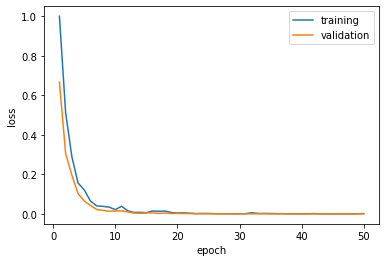

In [18]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 5. Evaluate model performance

A confusion matrix is plotted to see how well the model is predicting each class of image.

Getting predictions from test set...


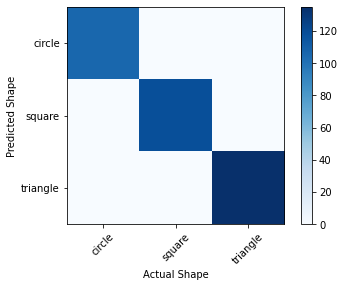

In [19]:
# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Actual Shape")
plt.ylabel("Predicted Shape")
plt.show()

## 6. Use the trained model

The model can now be used to predict classes for new images.

In [21]:
# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape): 
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Save the model weights
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)

out = widgets.Output(layout={'border': '0.5px solid black'})

def predict_Shape(button):
    # Create a random test image
    classnames = os.listdir(os.path.join('data', 'shapes'))
    classnames.sort()
    shape = classnames[randint(0, len(classnames)-1)]
    img = create_image ((128,128), shape)
    
    # Create a new model class and load weights
    model = Net()
    model.load_state_dict(torch.load(model_file))
    
    # Call the predction function
    index = predict_image(model, img)
    global out
    # Display the image
    plt.axis('off')
    plt.imshow(img)
    with out:
        print('The predicted shape is:', classes[index])
        
predict_button=widgets.Button(
description='Predict Shape',
disabled=False,
button_style='primary', 
tooltip="Click to randomly create a shape and see if the CNN correctly predicted it",
icon='refresh')

button_form = widgets.VBox([predict_button, out])

display(button_form)

predict_button.on_click(predict_Shape)

NameError: name 'model' is not defined